# Script to create the figure in section 5

This figure should represent a simulated cross-section of the snowpack, showing the layers' ages, on the area corresponding to the surface of a real snowpit.

## Imports and functions

In [1]:
%run little_awk_functions.py

In [2]:
import matplotlib.patches as mpatches
import matplotlib

## Select points and create dataset

In [3]:
# Select points of interest from CloudCompare

# interest_points = [[-7.25, 1.15], [-7.5, 1.4], [-7.75, 1.65], [-8, 1.9], [-8.25, 2.15], [-8.5, 2.4], [-8.75, 2.65], [-9, 2.9]]

# Pit 1
# nb_points_in_pit = 10
# x_range = np.linspace(-10.1, -11.61, num=nb_points_in_pit)
# y_range = np.linspace(1.4, -0.25, num=nb_points_in_pit)
# interest_points = [[x_range[i], y_range[i]] for i in range(nb_points_in_pit)]

# Pit 2
nb_points_in_pit = 10
x_range = np.linspace(-8.1, -9.11, nb_points_in_pit)
y_range = np.linspace(-1, 0.74, nb_points_in_pit)
interest_points = [[x_range[i], y_range[i]] for i in range(nb_points_in_pit)]

# Round points to existing coordinates > directly by hand?

# x = x//1 + x%1  where x%1 is always positive

interest_points_coords = interest_points
for i in range(len(interest_points_coords)):
    for j in range(2):
        interest_points_coords[i][j] = round(0.05 + 0.1*((interest_points_coords[i][j]-0.05)//0.1) + round((interest_points_coords[i][j]-0.05)%0.1, 1), 2)

x_min = min(interest_points_coords[i][0] for i in range(len(interest_points)))
x_max = max(interest_points_coords[i][0] for i in range(len(interest_points)))
y_min = min(interest_points_coords[i][1] for i in range(len(interest_points)))
y_max = max(interest_points_coords[i][1] for i in range(len(interest_points)))


In [4]:
print(interest_points_coords)

[[-8.05, -0.95], [-8.25, -0.85], [-8.35, -0.65], [-8.45, -0.45], [-8.55, -0.25], [-8.65, -0.05], [-8.75, 0.15], [-8.85, 0.35], [-8.95, 0.55], [-9.15, 0.75]]


In [5]:
# Convert points to coordinate indices

all_data_filled = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/data-filled/*.nc', chunks={'x': 20,'y': 20, 'time': 10})

# Convert coordinates to indices

# x: 201 points, from -19.95 to 0.05, steps of 0.1
# y: 91 points, from 4.55 to -4.45, steps of 0.1

x_inf = round(10*(x_min)+199.5)
x_sup = round(10*(x_max)+199.5)
y_inf = round(-10*(y_min)+45.5)
y_sup = round(-10*(y_max)+45.5)

sliced_data = all_data_filled.isel(x=slice(x_inf,x_sup+1), y=slice(y_sup,y_inf+1))
sliced_data.to_netcdf('sliced_data_pit.nc')   # TODO comment this if no use

## Clean dataset, pre-processing

In [4]:
# TODO subtract summer scans?

In [5]:
data_set_used = xr.open_dataset('sliced_data_pit.nc')

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 5, x_span=7)
median_time_filtering(data_set_used, 11)

data_set_used['snow_surface'] = data_set_used['snow_surface'] - data_set_used['snow_surface'].min()

---> Median filtering in space with a window [7, 11]
---> Median filtering in time with a window of 11


In [6]:
# data_set_used.isel(x=10, y=10)['snow_surface'].plot(figsize=(16, 5))

## Define parameters and variables

In [7]:
time_window_std = 25
std_threshold = 0.015

In [8]:
# Initial state for compaction/temperature model, with 0 layers

# Adaptable parameters
tsfc = -5   # TODO real value
cp_snow = 2106
dt = 100
a1 = 0.0013
a2 = 0.021

max_nb_of_layers = 25

use_true_temp = False   # set to True if want to use the correct temperature forcing

simul_new_snow_ro = 180           # TODO real value
simul_fit_top_of_snowfall_to_curve = False

# 'Fixed' parameters
tf = 0
ro_water = 1000
ro_ice = 910
jj = 0

In [9]:
# Define dates

data_starting_date_in_ns = float(data_set_used.time.values[0])

data_starting_date_in_s = pd.to_datetime(data_set_used.time.values[0]).timestamp()
data_ending_date_in_s = pd.to_datetime(data_set_used.time.values[-1]).timestamp()
data_duration_in_s = data_ending_date_in_s - data_starting_date_in_s
nb_iterations = int(data_duration_in_s/dt + 1)

In [10]:
# Meteorological forcing

if use_true_temp:
    met_time, met_temp = get_met_forcing()
else:
    met_time, met_temp = [0], [tsfc]

## Simulate snowpack at each point

In [11]:
# Define structures to store data for plotting

depth_data = np.zeros((len(interest_points), max_nb_of_layers))
age_data = np.zeros((len(interest_points), max_nb_of_layers))
offset_at_each_point = np.zeros((len(interest_points)))

In [12]:
# For one point of coordinates (x_coord, y_coord):

for point_nb in range(len(interest_points)):
    
    # Convert coordinates to indices

    x_coord = interest_points[point_nb][0]
    y_coord = interest_points[point_nb][1]

    x_sel = round(10*(x_coord-data_set_used.x.values[0]))
    y_sel = round(-10*(y_coord-data_set_used.y.values[0]))  # TODO adapter en fonction des dataset (?)

    # Define structures to store snow parameters

    ro_layer = np.zeros((max_nb_of_layers, 1))
    t_old = np.zeros((max_nb_of_layers, 1))
    dy_snow = np.zeros((max_nb_of_layers, 1))
    gamma = np.zeros((max_nb_of_layers, 1))
    melt_flag = np.zeros((max_nb_of_layers, 1))
    age_layers = np.zeros((max_nb_of_layers, 1))
    
    # Get timing of events

    results = get_snow_events(data_set_used, x_sel, y_sel, time_window_std, std_threshold)
    start_accumulation = results[0]
    start_erosion = results[1]
    end_accumulation = results[2]
    end_erosion = results[3]

    # Convert end times into more manageable orders of magnitude

    end_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation)
    end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

    end_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_erosion)
    end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

    # Simulate the snowpack

    snowpack = simulate_snowpack_evolution(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                       start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice,
                                       t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1, a2, met_temp_data=met_temp,
                                       met_time_data=met_time, new_snow_ro=simul_new_snow_ro, fit_top_of_snowfall_to_curve=simul_fit_top_of_snowfall_to_curve)

    ro_layer_evolution, depth_evolution, temperature_evolution = snowpack[0], snowpack[1], snowpack[2]   # TODO change selon recodage

    # Save data

    depth_data[point_nb] = depth_evolution[-1]
    age_data[point_nb] = [age_layers[i][0] for i in range(len(age_layers))]
    offset_at_each_point[point_nb] = float(data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=start_accumulation[0]))

## Plot data

In [13]:
# Transpose data for correct plotting

depth_data = list(depth_data.T)
age_data = list(age_data.T)

In [14]:
for i in range(len(age_data)):
    age_data[i] = list(age_data[i])
    
for i in range(len(depth_data)):
    depth_data[i] = list(depth_data[i])

In [15]:
print(offset_at_each_point)

[0.36604794 0.34506337 0.32567387 0.30769639 0.2838508  0.25762447
 0.22659322 0.19766451 0.18384132 0.15652829]


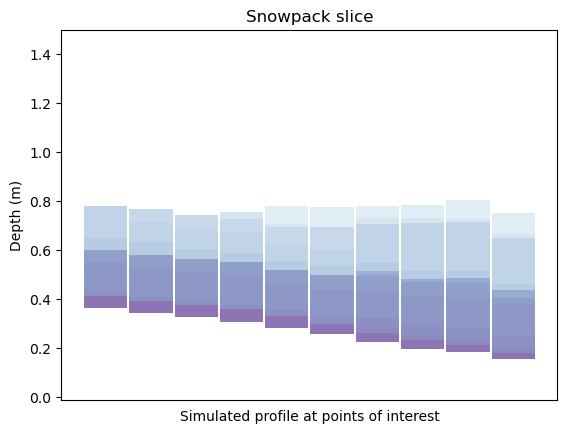

In [16]:
#data = [[depth of first layer at each point],
#        [depth of 2nd layer at each point], [...], ...]

# age_data = [[age of first layer at each point],
#             [age of 2nd layer at each point], [...], ...]

nb_age_slices = 25
age_slice_size = round((max(max(age_data))+1) / nb_age_slices)
# value that reflects the "closest" age value (around a certain range) genre diviser l'intervalle somehow automatically (max-min/nb_valeurs souhaitees)

# values = np.arange(0, 2, 500) # = [0, 500, 1000, 1500, 2000]        # TODO make modular

# Get some pastel shades for the colors
colors = list(reversed(plt.cm.BuPu(np.linspace(0.6, 0.1, nb_age_slices))))
# TODO will this be too continuous when the age will get super large?

color_to_use = []

index = np.arange(len(depth_data[0])) + 0.3
bar_width = 0.957

# Initialize the vertical-offset for the stacked bar chart.
# y_offset = np.zeros(len(depth_data[0]))           # TODO how to define offset? considering that all points might not start at the same initial height > take into account?
y_offset = offset_at_each_point

# Plot bars
for row in range(len(depth_data)):
    for i in range(len(depth_data[0])):
        color_to_use.append(colors[min(int(age_data[row][i]//age_slice_size), len(colors)-1)])
    plt.bar(index, depth_data[row], bar_width, bottom=y_offset, color=color_to_use)      #['b', 'r', 'g', 'y', 'm'])
    y_offset = y_offset + depth_data[row]
    color_to_use = []
    
# Reverse colors and text labels to display the last value at the top.
plt.ylabel("Depth (m)")
# plt.yticks(values, ['%d' % val for val in values])    # values, labels
plt.ylim([-0.01, 1.5])
plt.xlabel("Simulated profile at points of interest")
plt.xticks([])
plt.title('Snowpack slice')

# plt.colorbar()
# plt.savefig('simul_pit_X.png')

plt.show()

In [17]:
# TODO why is the bottom "old" layer only detected on some of the points?

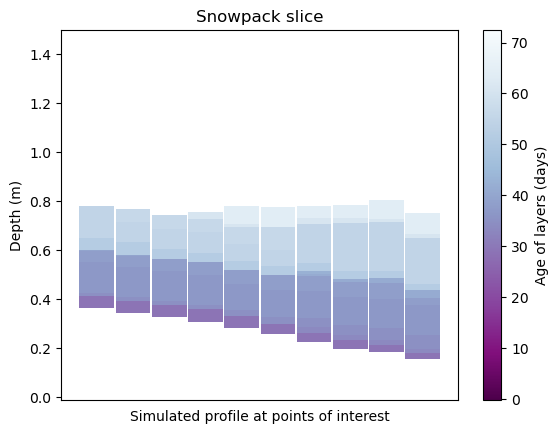

In [21]:
nb_age_slices = 25
age_slice_size = round((max(max(age_data))+1) / nb_age_slices)
# value that reflects the "closest" age value (around a certain range) genre diviser l'intervalle somehow automatically (max-min/nb_valeurs souhaitees)

# values = np.arange(0, 2, 500) # = [0, 500, 1000, 1500, 2000]        # TODO make modular

# Get some pastel shades for the colors
colors = list(reversed(plt.cm.BuPu(np.linspace(0.6, 0.1, nb_age_slices))))
# TODO will this be too continuous when the age will get super large?

color_to_use = []

index = np.arange(len(depth_data[0])) + 0.3
bar_width = 0.957

# Initialize the vertical-offset for the stacked bar chart.
y_offset = offset_at_each_point           # TODO how to define offset? considering that all points might not start at the same initial height > take into account?

# Plot bars
for row in range(len(depth_data)):
    for i in range(len(depth_data[0])):
        color_to_use.append(colors[min(int(age_data[row][i]//age_slice_size), len(colors)-1)])
    plt.bar(index, depth_data[row], bar_width, bottom=y_offset, color=color_to_use)      #['b', 'r', 'g', 'y', 'm'])
    y_offset = y_offset + depth_data[row]
    color_to_use = []
    
# Reverse colors and text labels to display the last value at the top.
plt.ylabel("Depth (m)")
# plt.yticks(values, ['%d' % val for val in values])    # values, labels
plt.ylim([-0.01, 1.5])
plt.xlabel("Simulated profile at points of interest")
plt.xticks([])
plt.title('Snowpack slice')

# plt.colorbar()
#color_names = ['blue', 'red']
#colors_list = ['b', 'r']

#plt.legend(handles=colors_list, labels=color_names, title="Age of layers")
max_age = (max(max(age_data))+1) / 3600 / 24

# Discrete labels
'''
color_patches = []
for i in range(len(colors)):
    color_patches.append(mpatches.Patch(color=colors[i], label='Layers of age '))#+str())
plt.legend(handles=color_patches, bbox_to_anchor=(1.31, 1), borderaxespad=0)
'''

cmap = matplotlib.cm.BuPu_r
norm = matplotlib.colors.Normalize(vmin=max_age, vmax=0)

plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='Age of layers (days)')


plt.show()


In [19]:
# Categoriser > use ages slices rather than exact value? Convert to more manageable ODG?
# TODO add legend with color correspondance > adjust colors used, invert orientation of colorbar
# TODO add map with position of the three points

In [20]:
ref_code = '''
data = [[ 66.386, 174.296,  75.131, 577.908,  32.015],
        [ 58.230, 381.139,  78.045,  99.308, 160.454],
        [ 89.135,  80.552, 152.558, 497.981, 603.535],
        [ 78.415,  81.858, 150.656, 193.263,  69.638],
        [139.361, 331.509, 343.164, 781.380,  52.269]]

age_data = [[1, 3, 2, 1, 1],
            [4, 5, 6, 7, 5],
            [7, 7, 7, 8, 6],
            [9, 8, 9, 9, 10],
            [11, 10, 10, 11, 12]]

nb_age_slices = 5
age_slice_size = round((max(max(age_data))+1) / nb_age_slices)
# value that reflects the "closest" age value (around a certain range) genre diviser l'intervalle somehow automatically (max-min/nb_valeurs souhaitees)

values = np.arange(0, 2500, 500) # = [0, 500, 1000, 1500, 2000]        # TODO make modular

# Get some pastel shades for the colors
colors = list(plt.cm.BuPu(np.linspace(0.5, 0, nb_age_slices)))

color_to_use = []

index = np.arange(len(data[0])) + 0.3
bar_width = 0.957

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(data[0]))

# Plot bars
for row in range(len(data)):
    for i in range(len(data[0])):
        color_to_use.append(colors[min(age_data[row][i]//age_slice_size, len(colors)-1)])
    plt.bar(index, data[row], bar_width, bottom=y_offset, color=color_to_use)
    y_offset = y_offset + data[row]
    color_to_use = []
    
# Reverse colors and text labels to display the last value at the top.
plt.ylabel("Depth (m)")
plt.yticks(values, ['%d' % val for val in values])    # values, labels
plt.xlabel("Simulated profile at points of interest")
plt.xticks([])
plt.title('Snowpack slice')

# plt.colorbar()

plt.show()
'''